#### Imports

In [1]:
from datetime import timedelta
import json
import pprint
from copy import deepcopy

import cufflinks
from matplotlib import pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
from tqdm.notebook import tqdm

from pyrecoy.assets import Heatpump, Eboiler, GasBoiler
from pyrecoy.colors import *
from pyrecoy.converters import *
from pyrecoy.financial import calculate_eb_ode, get_tax_tables, get_tax_rate, get_grid_tariffs_electricity
from pyrecoy.framework import TimeFramework, CaseStudy
from pyrecoy.plotting import ebitda_bar_chart, npv_bar_chart
from pyrecoy.reports import CaseReport, ComparisonReport, BusinessCaseReport, SingleFigureComparison
from pyrecoy.sensitivity import SensitivityAnalysis

%load_ext autoreload
%autoreload 2

#### Development backlog

* SDE++
* aFRR (can improve the optimisation case)
* Simple payback time (relevant for ENCORE, because its the main metric)
* APX inkoop toevoegen (baseload inkopen, bijv. 30%)
* Add explanations/conclusions to analysis/graph --> Create report-like output
* Graphs
    * EBITDA vs. baseline (earnings vs baseline)
* Show COP curves in different cases, just for illustration
* Energy report --> Check + add gas
* Fix comparison reports
* Model verification

#### Meeting Notes

##### Meeting 25-11-2020

* aFRR can help optimisation case
* SDE++ should be included
* Tsource sensitivity really gives interesting insights
* Sensitivities should be verified (especially CO2, Tsink, Tsource, time period)
* AP TNO: Update/verify COP curve
* AP TNO: Update CAPEX
* AP Mark: 
    * Create graphs on COP curve with different Tsource, Tsink
    * Generate table and output in .csv (send it to Andrew)
* Investigate opportunity to lower the COP and negative electricity prices
    * Technically feasible, but not really needed/possible to do it in this project
* Could be interesting to run this model on a usecase with higher delta T
* Conclusion: Finalize this model, but not add too much extra complexity, next steps is to go towards industrial partners with the results

# ENCORE : Heatpump Optimisation Framework

***
© Mark Kremer  
July 2020
##### Cases
In this model, 3 cases are compared:
* **Baseline** : All heat is supplied by steam turbine
* **Heatpump case** : All heat is supplied by heatpump
* **Hybrid case** : Steam turbine and heatpump run in hybrid mode, and are optimised on costs in real-time

#### Loading config

In [2]:
class Config():
    start = '2019-01-01'
    end = '2019-12-31'
    
    hp_vdg_e_power = 23.3 # MW
    hp_ndg_e_power = 7.7 # MW
    hp_min_load = 0.3
    hp_lifetime = 25
    hp_capex = 200_000 # EUR/MWth
    hp_opex = 0.01 # in % of CAPEX
    hp_devex = 0.005 # in % of CAPEX
    
    gb_power = 35 # MW
    gb_efficiency = 0.9
    
    tax_bracket_g = 4 
    tax_bracket_e = 4
    
    include_transport_costs = False
    grid_operator = 'Liander'
    connection_type = 'TS/MS'
    
    discount_rate = 0.1
    project_duration = 15

    forecast = 'ForeNeg'
    gas_price_multiplier = 1
    e_price_multiplier = 1
    e_price_volatility_multiplier = 1
    co2_price_multiplier = 1
    tsource_delta = 0
    energy_tax_multiplier = 1
    
c = Config()

In [3]:
class Store():
    pass

## Model set-up

In [4]:
def load_demand_data(c, s):
    demand = pd.read_csv('data/smurfit_demand_preprocessed.csv', delimiter=';', decimal=',')
    dt_index = pd.date_range(
        start=s.time_fw.start,
        end=s.time_fw.start + timedelta(days=365), freq='1T',
        closed='left',
        tz='Europe/Amsterdam')
    demand.index = dt_index
    demand['Total demand'] = demand['MW (VDG)'] + demand['MW (NDG)']
    demand = demand[c.start:c.end]
    return demand

In [5]:
def setup_model(c):
    s = Store()
    s.time_fw = TimeFramework(start=c.start, end=c.end)

    s.baseline = CaseStudy(time_fw=s.time_fw, freq='1T', name='Baseline')
    s.hpcase = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump only', forecast='mipf')
    s.optcase1 = CaseStudy(time_fw=s.time_fw, freq='1T', name='Optimisation', forecast='mipf')
    s.optcase2 = CaseStudy(time_fw=s.time_fw, freq='1T', name='Optimisation 2', forecast='mipf')
    
    s.cases = list(CaseStudy.get_instances().values())
    s.optcases = [s.hpcase, s.optcase1, s.optcase2]
    
    s.demand = load_demand_data(c, s)
    return s

s = setup_model(c)

## Load in data

In [6]:
def increase_volatility_by_factor(col, factor):
    mean = col.mean()
    diff_to_mean = col - mean
    new_diff = diff_to_mean * factor
    return mean + new_diff

def increase_by_factor(col, factor):
    mean = col.mean()
    diff_to_mean = col - mean
    
    cond = diff_to_mean > 0
    diff_to_mean[cond] *= factor
    diff_to_mean[~cond] /= factor
    return mean + diff_to_mean

In [7]:
def load_data(c, s):
    for case in [s.baseline, s.optcase1, s.optcase2]:
        case.add_gasprices()
        case.add_co2prices(perMWh=True)
        
        case.data['Gas prices (€/MWh)'] = increase_by_factor(case.data['Gas prices (€/MWh)'], c.gas_price_multiplier)
        case.data['CO2 prices (€/MWh)'] = increase_by_factor(case.data['CO2 prices (€/MWh)'], c.co2_price_multiplier)
    
    for case in s.optcases:
        case.data['NEG'] = increase_by_factor(case.data['NEG'], c.e_price_multiplier)
        case.data['ForeNeg'] = increase_by_factor(case.data['ForeNeg'], c.e_price_multiplier)
        case.data['DAM'] = increase_by_factor(case.data['DAM'], c.e_price_multiplier)
        
        case.data['NEG'] = increase_volatility_by_factor(case.data['NEG'], c.e_price_volatility_multiplier)
        case.data['ForeNeg'] = increase_volatility_by_factor(case.data['ForeNeg'], c.e_price_volatility_multiplier)
        
    s.demand[['Tsource (VDG)', 'Tsource (NDG)']] += c.tsource_delta
    for case in s.cases:
        case.data = pd.concat([case.data, s.demand], axis=1)        

    s.eb_ode_g = get_tax_rate('gas', 2020, 4)['EB+ODE'] * c.energy_tax_multiplier
    s.eb_ode_e = get_tax_rate('electricity', 2020, 4)['EB+ODE'] * c.energy_tax_multiplier
    s.grid_fees = get_grid_tariffs_electricity(c.grid_operator, 2020, c.connection_type)
    s.grid_fee_per_MWh = s.grid_fees['kWh tarief'] * 1000
    return s

s = load_data(c, s)

## Assets

### COP curve

In [8]:
def cop_curve(Tsink, Tsource):
    Tsink += 273
    Tsource += 273

    c1 = 0.267 * Tsink / (Tsink - Tsource)
    c2 = 0.333 * Tsink / (Tsink - Tsource)
    
    return Polynomial([c2, c1])

In [9]:
heatpump = Heatpump(
    name='Heatpump',
    max_th_power=1,
    min_th_power=0,
    cop_curve=cop_curve
)

In [10]:
import itertools

source_Ts = np.arange(25, 75)
sink_Ts   = np.arange(80, 170)

df = pd.DataFrame(columns=list(sink_Ts), index=list(source_Ts))
for sourceT, sinkT in itertools.product(source_Ts, sink_Ts):
    df.loc[sourceT, sinkT] = heatpump.get_cop(heat_output=0.5, Tsink=sinkT, Tsource=sourceT)
    
#df.to_csv('cops_at_50perc_load.csv', sep=';', decimal=',')

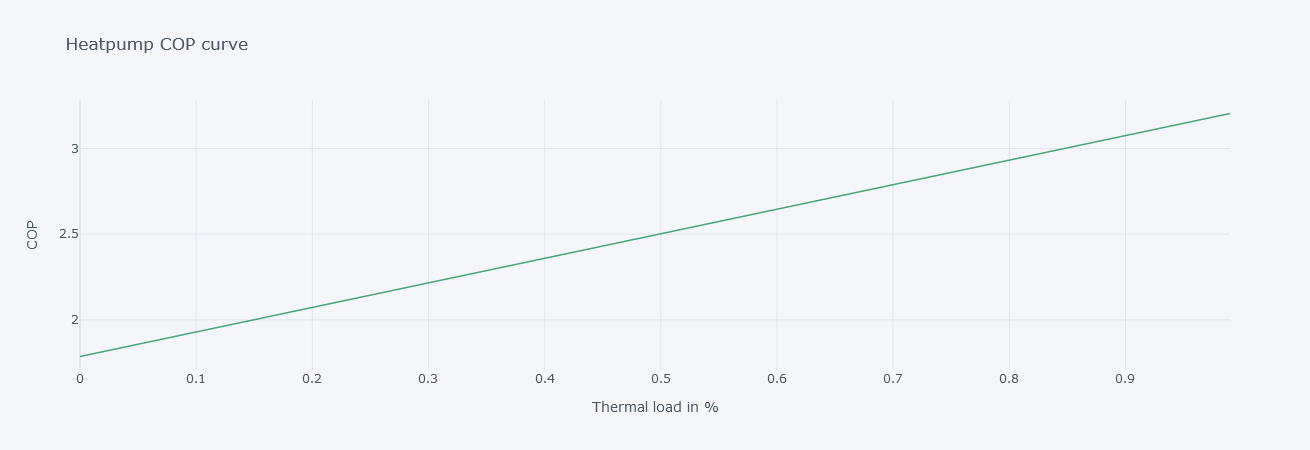

In [11]:
sourceT = 63
sinkT = 140
loads = np.arange(0, 1, 0.01)

series = pd.Series(index=loads, dtype='float')
for load in loads:
    series[load] = heatpump.get_cop(heat_output=load, Tsink=sinkT, Tsource=sourceT)
    
series.iplot(title='Heatpump COP curve', yTitle='COP', xTitle='Thermal load in %', colors=recoygreen)

### Create and assign assets

In [12]:
def create_and_assign_assets(c, s):
    heatpump_vdg = Heatpump(
        name='Heatpump VDG',
        max_th_power=c.hp_vdg_e_power,
        min_th_power=c.hp_vdg_e_power * c.hp_min_load,
        cop_curve=cop_curve
    )

    heatpump_ndg = Heatpump(
        name='Heatpump NDG',
        max_th_power=c.hp_ndg_e_power,
        min_th_power=c.hp_ndg_e_power * c.hp_min_load,
        cop_curve=cop_curve
    )

    capex_vdg = c.hp_capex*(heatpump_vdg.max_th_power) 
    capex_ndg = c.hp_capex*(heatpump_ndg.max_th_power)
    heatpump_vdg.set_financials(capex=capex_vdg, opex=c.hp_opex*capex_vdg, devex=c.hp_devex*capex_vdg, lifetime=25)
    heatpump_ndg.set_financials(capex=capex_ndg, opex=c.hp_opex*capex_ndg, devex=c.hp_devex*capex_ndg, lifetime=25)

    gasboiler = GasBoiler(
        name='Gasboiler',
        max_th_output=c.gb_power,
        efficiency=c.gb_efficiency
    )
    gasboiler.set_financials(capex=0, opex=0, devex=0, lifetime=25)
    
    s.baseline.add_asset(gasboiler)
    s.hpcase.add_asset(heatpump_vdg)
    s.hpcase.add_asset(heatpump_ndg)
    s.optcase1.add_asset(heatpump_vdg)
    s.optcase1.add_asset(heatpump_ndg)
    s.optcase1.add_asset(gasboiler)
    s.optcase2.add_asset(heatpump_vdg)
    s.optcase2.add_asset(heatpump_ndg)
    s.optcase2.add_asset(gasboiler)
    return s

s = create_and_assign_assets(c, s)

In [13]:
s.baseline.data.describe()

Gas prices (€/MWh)  CO2 prices (€/ton)  CO2 prices (€/MWh)  \
count       525600.000000       525600.000000       525600.000000   
mean            13.538745           24.864018            4.683144   
std              3.644779            2.142574            0.403827   
min              7.530000           18.700000            3.520000   
25%             10.380000           23.670000            4.460000   
50%             12.850000           25.080000            4.720000   
75%             15.600000           26.290000            4.950000   
max             22.670000           29.770000            5.610000   

       Tsource (VDG)    Tsink (VDG)       MW (VDG)  Tsource (NDG)  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean       63.658798     138.637674      17.636712      62.176305   
std         6.422773      14.328580       5.123252      10.252555   
min        25.310000      82.480000       0.000000      13.540000   
25%        64.892000     126.074000      17.014000      63.516000   
50%        64.991000     142.450000      19.892000      64.313000   
75%        65.076000     151.730000      20.819000      65.546000   
max        70.070000     166.020000      23.250000      73.470000   

         Tsink (NDG)       MW (NDG)   Total demand  
count  525600.000000  525600.000000  525600.000000  
mean      145.351645       5.823824      23.460537  
std        14.896056       1.691697       6.814125  
min       106.330000       0.000000       0.000000  
25%       131.551500       5.612000      22.676000  
50%       148.490000       6.540000      26.441000  
75%       158.100000       6.880000      27.690000  
max       172.050000       7.650000      30.900000

In [14]:
heatpump = Heatpump(
    name='Heatpump',
    max_th_power=1,
    min_th_power=0,
    cop_curve=cop_curve
)

## Optimization

### Strategies

In [15]:
def baseline_sim(case):
    gasboiler = list(case.assets.values())[0]
    data = case.data
    demand = (data['MW (VDG)'] + data['MW (NDG)']).to_list()

    minutes = iter(range(len(case.data)))
    th_output = [0] * len(case.data)
    gas_input = [0] * len(case.data)

    for m in minutes:
        th_output[m], gas_input[m] = gasboiler.set_heat_output(demand[m])

    data['output_MW_th'] = np.array(th_output)
    data['output_MWh_th'] = np.array(data['output_MW_th']/60)
    data['gb_input_MW'] = np.array(gas_input)
    data['gb_input_MWh'] = np.array(data['gb_input_MW']/60)
    case.data = data.round(5)

In [16]:
def hponly(case):
    hp_vdg = case.assets['Heatpump VDG']
    hp_ndg = case.assets['Heatpump NDG']
    demand_vdg = case.data['MW (VDG)'].to_list()
    demand_ndg = case.data['MW (NDG)'].to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].to_list()
    Tsink_ndg = case.data['Tsink (NDG)'].to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].to_list()
    Tsource_ndg = case.data['Tsource (NDG)'].to_list()

    hp_vdg_input = [0] * len(case.data)
    hp_ndg_input = [0] * len(case.data)
    hp_vdg_output = [0] * len(case.data)
    hp_ndg_output = [0] * len(case.data)

    minutes = iter(range(len(case.data)))
    for m in minutes:
        demand = demand_vdg[m]
        if demand != 0:
            hp_vdg_output[m], hp_vdg_input[m] = hp_vdg.set_heat_output(
                heat_output=demand,
                Tsink=Tsink_vdg[m],
                Tsource=Tsource_vdg[m]
            )

        demand = demand_ndg[m]
        if demand != 0:
            hp_ndg_output[m], hp_ndg_input[m] = hp_ndg.set_heat_output(
                heat_output=demand_ndg[m],
                Tsink=Tsink_ndg[m],
                Tsource=Tsource_ndg[m]
            )

    case.data['hp_output_MW'] = np.array(hp_vdg_output) + np.array(hp_ndg_output)
    case.data['hp_input_MW'] = np.array(hp_vdg_input) + np.array(hp_ndg_input)

    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(3)

In [17]:
def strategy(case, decimals, tolerance, s):
    gb = case.assets['Gasboiler']
    hp_vdg = case.assets['Heatpump VDG']
    hp_ndg = case.assets['Heatpump NDG']
    demand_vdg = case.data['MW (VDG)'].round(decimals).to_list()
    demand_ndg = case.data['MW (NDG)'].round(decimals).to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].round(decimals).to_list()
    Tsink_ndg = case.data['Tsink (NDG)'].round(decimals).to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].round(decimals).to_list()
    Tsource_ndg = case.data['Tsource (NDG)'].round(decimals).to_list()
    fore_neg = case.data[c.forecast].fillna(999).round(decimals).to_list()
    gas_prices = case.data['Gas prices (€/MWh)'].round(decimals).to_list()
    co2_prices = case.data['CO2 prices (€/MWh)'].round(decimals).to_list()
    eb_ode_g = s.eb_ode_g
    eb_ode_e = s.eb_ode_e
    
    gb_input = [0] * len(case.data)
    gb_output = [0] * len(case.data)

    minutes = range(len(case.data))
    hp_output = [0] * len(case.data)
    hp_input = [0] * len(case.data)

    for m in tqdm(minutes):
        dem_vgd = demand_vdg[m]
        if dem_vgd != 0:
            hp_vdg_input, hp_vdg_output = hp_vdg.set_opt_load(
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd,
                Tsink=Tsink_vdg[m],
                Tsource=Tsource_vdg[m],
                tolerance=tolerance
            )
        else:
            hp_vdg_input, hp_vdg_output = (0, 0)

        dem_ngd = demand_ndg[m]
        if dem_ngd != 0:
            hp_ndg_input, hp_ndg_output = hp_ndg.set_opt_load(
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=(gas_prices[m] + co2_prices[m] + eb_ode_g)/case.assets['Gasboiler'].efficiency,
                demand=dem_ngd,
                Tsink=Tsink_ndg[m],
                Tsource=Tsource_ndg[m],
                tolerance=tolerance
            )
        else:
            hp_ndg_input, hp_ndg_output = (0, 0)

        hp_out = hp_vdg_output + hp_ndg_output
        hp_output[m] = hp_out
        hp_input[m] = hp_vdg_input + hp_ndg_input
        remaining_demand = max(dem_vgd+dem_ngd-hp_out, 0)
        gb_output[m], gb_input[m] = gb.set_heat_output(remaining_demand)

    case.data['hp_output_MW'] = np.array(hp_output)
    case.data['hp_input_MW'] = np.array(hp_input)
    case.data['gb_output_MW'] = np.array(gb_output)
    case.data['gb_input_MW'] = np.array(gb_input)

    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(5)

In [18]:
def cost_function(th_load, cop, electricity_cost, alt_heat_price, demand):
        return (
            th_load / cop * electricity_cost
            + (demand - th_load) * alt_heat_price
        )

In [19]:
def strategy_(case, decimals, s):
    gb = case.assets['Gasboiler']
    hp_vdg = case.assets['Heatpump VDG']
    hp_ndg = case.assets['Heatpump NDG']
    demand_vdg = case.data['MW (VDG)'].round(decimals).to_list()
    demand_ndg = case.data['MW (NDG)'].round(decimals).to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].round(decimals).to_list()
    Tsink_ndg = case.data['Tsink (NDG)'].round(decimals).to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].round(decimals).to_list()
    Tsource_ndg = case.data['Tsource (NDG)'].round(decimals).to_list()
    fore_neg = case.data[c.forecast].fillna(999).round(decimals).to_list()
    gas_prices = case.data['Gas prices (€/MWh)'].round(decimals).to_list()
    co2_prices = case.data['CO2 prices (€/MWh)'].round(decimals).to_list()
    eb_ode_g = s.eb_ode_g
    eb_ode_e = s.eb_ode_e
    
    gb_input = [0] * len(case.data)
    gb_output = [0] * len(case.data)

    minutes = range(len(case.data))
    hp_output = [0] * len(case.data)
    hp_input = [0] * len(case.data)

    for m in tqdm(minutes):
        dem_vgd = demand_vdg[m]
        if dem_vgd != 0:
            max_load = min(hp_vdg.max_th_power, dem_vgd)
            min_load = hp_vdg.min_th_power
            Tsink = Tsink_vdg[m]
            Tsource = Tsource_vdg[m]
            cop_max_load = hp_vdg.get_cop(heat_output=max_load, Tsink=Tsink, Tsource=Tsource)
            cop_min_load = hp_vdg.get_cop(heat_output=min_load, Tsink=Tsink_vdg[m], Tsource=Tsource_vdg[m])
            
            cost_full_load = cost_function(
                th_load=max_load,
                cop=cop_max_load,
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            cost_min_load = cost_function(
                th_load=min_load,
                cop=cop_min_load,
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            if cost_full_load < cost_min_load:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(max_load, Tsink, Tsource)
            else:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(min_load, Tsink, Tsource)
        else:
            hp_vdg_input, hp_vdg_output = (0, 0)

        dem_ngd = demand_ndg[m]
        if dem_ngd != 0:
            max_load = min(hp_ndg.max_th_power, dem_ngd)
            min_load = hp_ndg.min_th_power
            Tsink = Tsink_ndg[m]
            Tsource = Tsource_ndg[m]
            cop_max_load = hp_ndg.get_cop(heat_output=max_load, Tsink=Tsink, Tsource=Tsource)
            cop_min_load = hp_ndg.get_cop(heat_output=min_load, Tsink=Tsink, Tsource=Tsource)
            
            cost_full_load = cost_function(
                th_load=max_load,
                cop=cop_max_load,
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_ngd
            )
            
            cost_min_load = cost_function(
                th_load=min_load,
                cop=cop_min_load,
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            if cost_full_load <= cost_min_load:
                hp_ndg_input, hp_ndg_output = hp_ndg.set_heat_output(max_load, Tsink=Tsink, Tsource=Tsource)
            else:
                hp_ndg_input, hp_ndg_output = hp_ndg.set_heat_output(min_load, Tsink=Tsink, Tsource=Tsource)
        else:
            hp_ndg_input, hp_ndg_output = (0, 0)

        hp_out = hp_vdg_output + hp_ndg_output
        hp_output[m] = hp_out
        hp_input[m] = hp_vdg_input + hp_ndg_input
        remaining_demand = max(dem_vgd+dem_ngd-hp_out, 0)
        gb_output[m], gb_input[m] = gb.set_heat_output(remaining_demand)

    case.data['hp_output_MW'] = np.array(hp_output)
    case.data['hp_input_MW'] = np.array(hp_input)
    case.data['gb_output_MW'] = np.array(gb_output)
    case.data['gb_input_MW'] = np.array(gb_input)

    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(5)

### Run optimisation

In [ ]:
def run_optimisation(c, s):
    s.baseline.assign_algorithm(baseline_sim)
    %time s.baseline.run()
    
    s.hpcase.assign_algorithm(hponly)
    %time s.hpcase.run()
    
    s.optcase1.assign_algorithm(strategy)
    %time s.optcase1.run(decimals=0, tolerance=1, s=s)

    s.optcase2.assign_algorithm(strategy_)
    %time s.optcase2.run(decimals=2, s=s)
    return s

s = run_optimisation(c, s)

Wall time: 1.93 s


c:\users\mekre\onedrive - recoy\work\code\python\_packages\pyrecoy\pyrecoy\assets.py:253: UserWarning:

Chosen heat output is out of range [6.99 - 23.3]. Heat output is being limited to the closest boundary.

c:\users\mekre\onedrive - recoy\work\code\python\_packages\pyrecoy\pyrecoy\assets.py:253: UserWarning:

Chosen heat output is out of range [2.31 - 7.7]. Heat output is being limited to the closest boundary.



Wall time: 13.6 s


In [ ]:
s.optcase1.data.columns

In [ ]:
s.optcase1.data['hp_input_MW']

In [ ]:
s.optcase2.data['hp_input_MW']

## Financials

In [ ]:
# SDE++
# ...

In [ ]:
def collect_cashflows(c, s):
    s.hpcase.generate_electr_market_results(nom_col='hp_input_MWh', real_col='hp_input_MWh')
    s.optcase1.generate_electr_market_results(nom_col=None, real_col='hp_input_MWh')
    s.optcase2.generate_electr_market_results(nom_col=None, real_col='hp_input_MWh')
        
    for case in [s.baseline, s.optcase1, s.optcase2]:
        case.add_gas_costs(gasvolumes_col='gb_input_MWh')
        case.add_co2_costs(volume_cols='gb_input_MWh', fuel='gas')
        case.add_eb_ode(commodity='gas', tax_bracket=c.tax_bracket_g)
        
    for case in [s.hpcase, s.optcase1, s.optcase2]:
        case.add_eb_ode(commodity='electricity', tax_bracket=c.tax_bracket_e)
        case.add_grid_costs(
            power_MW_col='hp_input_MW',
            grid_operator=c.grid_operator,
            year=2020, 
            connection_type=c.connection_type
        )
        
    return s

s = collect_cashflows(c, s)

In [ ]:
def calculate_financials(c, s):
    for case in s.cases:
        case.calculate_ebitda()

    for case in [s.optcase1, s.optcase2]:
        case.calculate_business_case(
            project_duration=c.project_duration, 
            discount_rate=c.discount_rate, 
            baseline=s.baseline
        )
        
    return s

s = calculate_financials(c, s)

## Visualisations

In [ ]:
s.demand['Total demand'].resample('H').mean().iplot(title='Heat demand by Hour in MW', yTitle='MW', colors=recoygreen)

In [ ]:
s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].plot(kind='box')

In [ ]:
s.optcase1.data.columns

In [ ]:
test_hp = Heatpump(
    name='Heatpump for Testing',
    max_th_power=1,
    min_th_power=0.3,
    cop_curve=cop_curve
)

In [ ]:
Tsrc_vdg, Tsnk_vdg, Tsrc_ndg, Tsnk_ndg = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].mean().to_list()
mean_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].mean() 
             + s.eb_ode_g 
             + s.optcase1.data['CO2 prices (€/MWh)'].mean()
            )

max_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].max() 
             + s.eb_ode_g 
             + s.optcase1.data['CO2 prices (€/MWh)'].max()
            )

min_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].min() 
             + s.eb_ode_g 
             + s.optcase1.data['CO2 prices (€/MWh)'].min()
            )

Tsrc_vdg_min, Tsnk_vdg_min, Tsrc_ndg_min, Tsnk_ndg_min = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].min().to_list()
Tsrc_vdg_max, Tsnk_vdg_max, Tsrc_ndg_max, Tsnk_ndg_max = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].max().to_list()

In [ ]:
def create_load_trace(gas_price, Tsnk, Tsrc, name):
    loads = []
    eprices = list(range(500))
    for eprice in eprices:
        _, load = test_hp.set_opt_load(
            electricity_cost=eprice + s.eb_ode_e,
            alt_heat_price=gas_price / 0.9,
            demand=1, 
            Tsink=Tsnk,
            Tsource=Tsrc
        )
        loads.append(load)
    trace = go.Scatter(x=eprices, y=loads, name=name)
    return trace

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

configs = {
    'mean': [mean_gas_price, Tsnk_vdg, Tsrc_vdg],
    'unfav_gas': [min_gas_price, Tsnk_vdg, Tsrc_vdg],
    'fav_gas': [max_gas_price, Tsnk_vdg, Tsrc_vdg],
    'unfav_all': [min_gas_price, Tsnk_vdg_max, Tsrc_vdg_min],
    'fav_all': [max_gas_price, Tsnk_vdg_min, Tsrc_vdg_max],
}

for name, config in configs.items():
    trace = create_load_trace(*config, name)
    fig.add_trace(trace)

fig.update_layout(title='Switch prices for different configurations')
fig.show()

In [ ]:
date = '2019-01-01'
s.baseline.data[['Total demand', 'output_MW_th', 'gb_input_MW']].abs().loc[date, :].iplot(
    subplots=True, 
    title=f'Baseline case on {date}',
    subplot_titles=['Total demand', 'Steam boiler output (MW)', 'Steam boiler input (MW)'],
    legend=False,
    dimensions=(1000, 500)
)

In [ ]:
s.hpcase.data[['Total demand', 'hp_output_MW', 'hp_input_MW']].abs().loc[date, :].iplot(
    subplots=True, 
    title=f'Heatpump case on {date}', 
    subplot_titles=['Total demand', 'Heatpump output(MW)', 'Heatpump input (MW)'],
    legend=False,
    dimensions=(1000, 500)
)

In [ ]:
fig = s.optcase1.data[['Total demand', 'hp_output_MW', 'hp_input_MW', 'gb_output_MW', 'gb_input_MW', 'NEG', 'Gas prices (€/MWh)']].loc[date, :].iplot(
    subplots=True, 
    title=f'Hybrid case on {date}',
    subplot_titles=['Total demand (MW)', 'Heatpump output (MW)', 'Heatpump input (MW)', 'Steam boiler output (MW)', 'Steam boiler input (MW)', 'Imbalance price (€/MWh)', 'Gas price (€/MWh)'],
    legend=False,
    dimensions=(1000, 600)
)

In [ ]:
report = ComparisonReport(
    cases=s.optcases, 
    kind='electr_market_results',
)
report.show()

In [ ]:
casereport = ComparisonReport(cases = s.cases, kind='ebitda_calc')
casereport.show(presentation_format=True)

In [ ]:
BusinessCaseReport(s.optcase1).show()

In [ ]:
#price chart
from copy import deepcopy

data = deepcopy(s.baseline.data)
data = data[data.columns[:2]]
data[data.columns[1]] = MWh_gas_to_tonnes_CO2(data[data.columns[1]])
data = data.rename(columns={"CO2 prices (€/ton)": "CO2 prices (€/MWh)"})

data.resample('D').mean().iplot(dimensions=(800, 300), title='Gasprices vs. CO2 prices')

In [ ]:
_source_output = s.optcase1.data[['hp_output_MWh', 'gb_output_MWh']].resample('M').sum()
_total_output = _source_output.sum(axis=1)
_data = _source_output.divide(_total_output, axis=0).rename(
    columns={'hp_output_MWh':'Heat pump', 'gb_output_MWh':'Gasboiler'}
) * 100

_data.iplot(
    kind='bar',
    barmode='stack',
    colors=[recoydarkblue, recoygreen],
    title='Hybrid case: Heat production per Month by Source in % share',
    yTitle='Share of production in %',
    dimensions=(600, 400)
)

In [ ]:
report = ComparisonReport(s.cases, kind='capex').report
report = report[report.index.str.contains('CAPEX')].T
report.iplot(
    kind='bar', 
    barmode='relative',
    colors=recoycolors,
    title='CAPEX by Casestudy',
    yTitle='CAPEX in €',
    dimensions=(600, 400)
)

In [ ]:
cashflow_report = ComparisonReport(cases = s.cases, kind='cashflows')

fig = cashflow_report.report.T.iplot(
    kind='bar',
    barmode='relative',
    colors=recoycolors,
    title='OPEX breakdown',
    asFigure=True,
    yTitle='€',
    dimensions=(600, 400)
)

ebitda_report = ComparisonReport(cases=s.cases, kind='ebitda_calc')
scat = go.Scatter(
    mode='markers',
    y=ebitda_report.report.loc['EBITDA (€)', :].values, 
    x=ebitda_report.report.columns, 
    line=go.scatter.Line(color=recoydarkgrey),
    marker=dict(
        color=recoydarkgrey,
        size=20,
        line=dict(
            color=recoydarkgrey,
            width=3
        ),
        symbol='line-ew'
    ),
    name='EBITDA (€)'
)
fig.add_trace(scat)
fig

In [ ]:
SingleFigureComparison(s.optcases, 'npv', label='NPV').report.iplot(
    kind='bar',
    title='NPV by Casestudy in €',
    colors=recoygreen,
    dimensions=(600, 400)
)

In [ ]:
(SingleFigureComparison(s.optcases, 'irr', label='IRR').report * 100).iplot(
    kind='bar',
    title='IRR by Casestudy in %',
    colors=recoygreen,
    dimensions=(600, 400)
)

## Sensitivity analysis

We have agreed that for the sensitivity analysis we will vary the following key assumptions in the flex-model:
1. Market prices of gas and electricity. We will use the actual prices for 2019, the actual prices for 2020 and two simulated years based on the prices in 2019 +30% and 2019 -30% . __Check 2018 results__
2. __aFRR prices +/- 30%__
3. CAPEX __(add +100% scenario's, CAPEX is w/out integration costs - integration costs might be very high.)__
4. CO2 price __(larger impacts expected, check calculations, try higher levels of 50-100-150€/ton average)__
5. Tsource +/- 10 degrees Celsius __Verify results__
6. __Tsink__ 
    * +/- 10 degrees celcius
    * Roam off the peak / lower pressure
    * Stabalize / running average per hour/ 2 hours
7. __A scenario with a constraint on grid capacity and a scenario without grid capacity as a constraint__
8. Energy Tax and ODE +/- 30%

In [ ]:
def setup():
    _c = Config()
    s = setup_model(c=_c)
    return s

def routine(c, s):
    s = load_data(c=c, s=s)
    s = create_and_assign_assets(c=c, s=s)
    s = run_optimisation(c=c, s=s)
    s = collect_cashflows(c=c, s=s)
    s = calculate_financials(c=c, s=s)
    return s

In [ ]:
#%time _s = setup()

In [ ]:
#%time result = routine(c, _s)
#npv = result.hpcase.npv
#npv

### Sensitivity: Heat Pump CAPEX

In [ ]:
_s = setup()
configs = {}
values = [c.hp_capex * mult for mult in [0.7, 1, 1.3]]
for value in values:
    _c = Config()
    _c.hp_capex = value
    configs[value] = _c

In [ ]:
%%time
sens1 = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output1 = sens1.single_kpi_overview('npv', case_names=['Heatpump only', 'Optimisation'])
output1.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='CAPEX (€)',
    yTitle='NPV in €',
    yrange=[0, output1.max().max()*1.1],
    title='Sensitivity: Heat Pump CAPEX (€)',
    colors=[recoygreen, recoyyellow],
    dimensions=(600, 400)
)

### Sensitivity: CO2 prices

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.co2_price_multiplier = value
    configs[value] = _c

In [ ]:
%%time
sens4 = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens4.single_kpi_overview('irr', case_names=['Heatpump only', 'Optimisation'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='CO2 price factor',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: CO2 prices',
    colors=[recoygreen, recoyyellow],
    dimensions=(600, 400)
)

### Sensitivity: Gas prices

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.gas_price_multiplier = value
    configs[value] = _c

In [ ]:
%%time
sens3 = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens3.single_kpi_overview('npv', case_names=['Heatpump only', 'Optimisation'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Gas price factor',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Gas prices',
    colors=[recoygreen, recoyyellow],
    dimensions=(600, 400)
)

### Sensitivity: Electricity prices

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.e_price_multiplier = value
    configs[value] = _c

In [ ]:
%%time
sens5 = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens5.single_kpi_overview('npv', case_names=['Heatpump only', 'Optimisation'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Electricity price factor',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Electricity prices',
    colors=[recoygreen, recoyyellow],
    dimensions=(600, 400)
)

### Sensitivity: Electricity price volatility

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.e_price_volatility_multiplier = value
    configs[value] = _c

In [ ]:
%%time
sens6 = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens6.single_kpi_overview('npv', case_names=['Heatpump only', 'Optimisation'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Volatility factor',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: E-price volatility',
    colors=[recoygreen, recoyyellow],
    dimensions=(600, 400)
)

### Sensitivity: Energy tax

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.energy_tax_multiplier = value
    configs[value] = _c

In [ ]:
%%time
sens8 = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens8.single_kpi_overview('npv', case_names=['Heatpump only', 'Optimisation'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Factor',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Energy taxes',
    colors=[recoygreen, recoyyellow],
    dimensions=(600, 400)
)

### Sensitivity: Tsource

In [ ]:
_s = setup()
configs = {}
values = [-10, 0, 10]
for value in values:
    _c = Config()
    _c.tsource_delta = value
    configs[value] = _c

In [ ]:
%%time
sens7 = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens7.single_kpi_overview('npv', case_names=['Heatpump only', 'Optimisation'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsource delta',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsource',
    colors=[recoygreen, recoyyellow],
    dimensions=(600, 400)
)

### Sensitivity: Time period

In [ ]:
def routine2(c, s):
    s = setup_model(c=c)
    s = load_data(c=c, s=s)
    s = create_and_assign_assets(c=c, s=s)
    s = run_optimisation(c=c, s=s)
    s = collect_cashflows(c=c, s=s)
    s = calculate_financials(c=c, s=s)
    return s

In [ ]:
configs = {}
start_values = ['2018-01-01', '2019-01-01', '2019-11-01']

for value in start_values:
    _c = Config()
    _c.start = value
    _c.end = (pd.to_datetime(value) + timedelta(days=364)).strftime('%Y-%m-%d')
    configs[value] = _c

In [ ]:
%%time
sens2 = SensitivityAnalysis(_s, routine2, configs)

In [ ]:
result2 = sens2.single_kpi_overview('npv', case_names=['Heatpump only', 'Optimisation'])
result2.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Start date',
    yTitle='NPV in €',
    yrange=[0, result2.max().max()*1.1],
    title='Sensitivity: Modelled time period',
    colors=[recoygreen, recoyyellow],
    dimensions=(600, 400)
)